          observation_date           DFF   rate_change
count                25823  25823.000000  25823.000000
mean   1989-11-06 00:00:00      4.608863      0.000124
min    1954-07-02 00:00:00      0.040000     -7.890000
25%    1972-03-04 12:00:00      1.840000      0.000000
50%    1989-11-06 00:00:00      4.330000      0.000000
75%    2007-07-10 12:00:00      6.180000      0.000000
max    2025-03-13 00:00:00     22.360000      7.790000
std                    NaN      3.579192      0.312564

Premières lignes des données:
   observation_date   DFF  rate_change
1       1954-07-02  1.25         0.12
2       1954-07-03  1.25         0.00
3       1954-07-04  1.25         0.00
4       1954-07-05  0.88        -0.37
5       1954-07-06  0.25        -0.63

Skewness: 0.7875037079568984
Kurtosis: 72.4842279878938


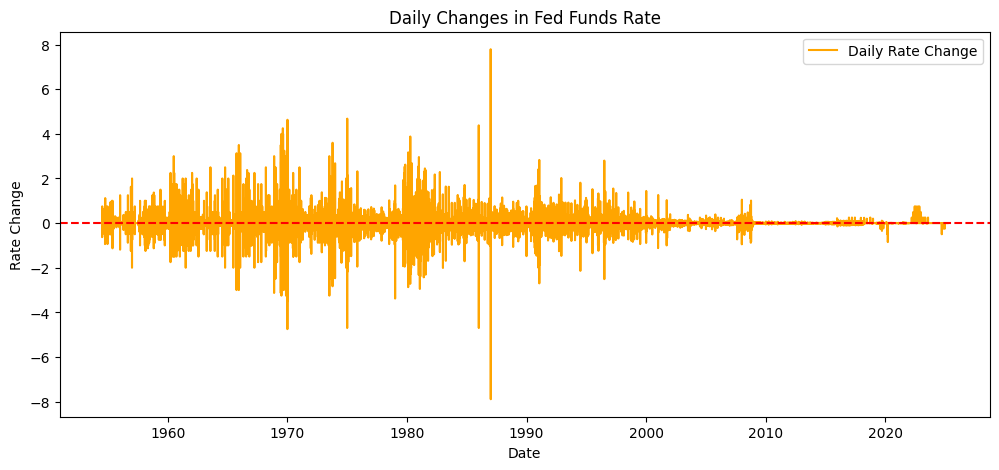

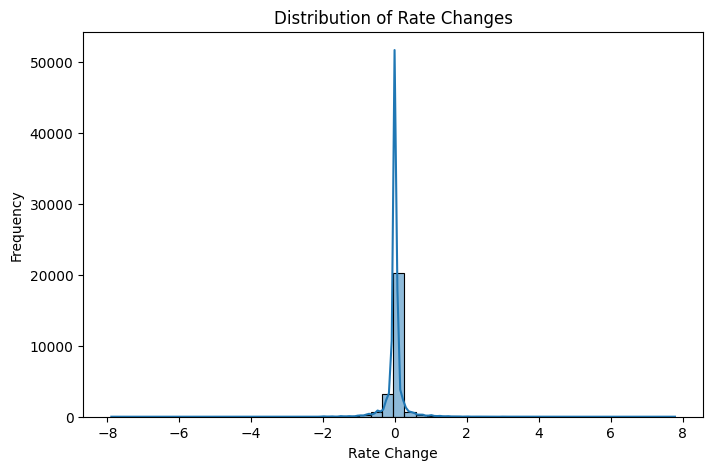

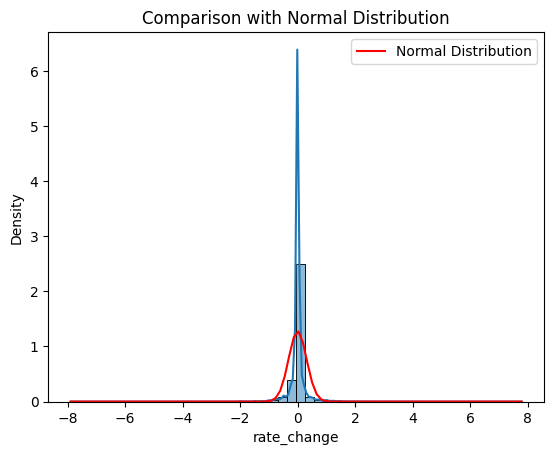

GEV Parameters:
Shape: -0.28840174965611654, Location: 0.813070408057261, Scale: 0.8770092153431437
GP Parameters:
Shape: 0.20416548999784806, Scale: 0.4083967259554096
The estimated 100-year rate change is: 3.38158


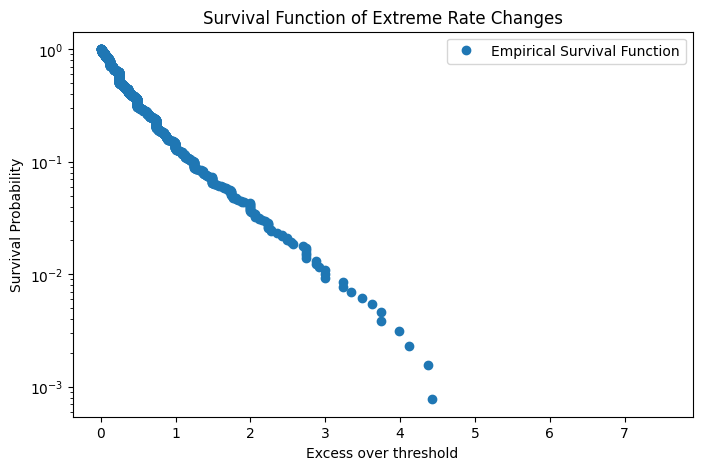

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genextreme, genpareto, norm, skew, kurtosis

# Importation des données
df = pd.read_csv("DFF.csv")
df["observation_date"] = pd.to_datetime(df["observation_date"])
df["DFF"] = df["DFF"].ffill()
df["rate_change"] = df["DFF"].diff()
df.dropna(inplace=True)

# Analyse descriptive
print(df.describe())
print("\nPremières lignes des données:\n", df.head())
print("\nSkewness:", skew(df["rate_change"]))
print("Kurtosis:", kurtosis(df["rate_change"]))

# Visualisation des variations
plt.figure(figsize=(12, 5))
plt.plot(df["observation_date"], df["rate_change"], label="Daily Rate Change", color="orange")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Daily Changes in Fed Funds Rate")
plt.xlabel("Date")
plt.ylabel("Rate Change")
plt.legend()
plt.show()

# Histogramme des variations
plt.figure(figsize=(8,5))
sns.histplot(df["rate_change"], bins=50, kde=True)
plt.title("Distribution of Rate Changes")
plt.xlabel("Rate Change")
plt.ylabel("Frequency")
plt.show()

# Test de normalité
sns.histplot(df["rate_change"], kde=True, stat="density", bins=50)
x = np.linspace(df["rate_change"].min(), df["rate_change"].max(), 100)
plt.plot(x, norm.pdf(x, df["rate_change"].mean(), df["rate_change"].std()), color="red", label="Normal Distribution")
plt.legend()
plt.title("Comparison with Normal Distribution")
plt.show()

# Block Maxima (GEV)
df["Year"] = df["observation_date"].dt.year
maxima_data = df.groupby("Year")["rate_change"].max()

shape, loc, scale = genextreme.fit(maxima_data)
print("GEV Parameters:")
print(f"Shape: {shape}, Location: {loc}, Scale: {scale}")

# Peak Over Threshold (GP)
threshold = np.percentile(df["rate_change"], 95)
excesses = df["rate_change"][df["rate_change"] > threshold] - threshold

shape_gp, loc_gp, scale_gp = genpareto.fit(excesses)
print("GP Parameters:")
print(f"Shape: {shape_gp}, Scale: {scale_gp}")

# Estimation de l'extrême à 100 ans
century_change = genpareto.ppf(1 - 1/100, shape_gp, loc=0, scale=scale_gp) + threshold
print(f"The estimated 100-year rate change is: {century_change:.5f}")

# Courbe de survie pour EVT
sorted_excesses = np.sort(excesses)
cdf = np.arange(1, len(sorted_excesses) + 1) / len(sorted_excesses)
plt.figure(figsize=(8, 5))
plt.plot(sorted_excesses, 1 - cdf, marker="o", linestyle="none", label="Empirical Survival Function")
plt.title("Survival Function of Extreme Rate Changes")
plt.xlabel("Excess over threshold")
plt.ylabel("Survival Probability")
plt.yscale("log")
plt.legend()
plt.show()

# Export des résultats
df.to_csv("processed_DFF.csv", index=False)
np.savetxt("gev_params.txt", [shape, loc, scale], header="Shape, Location, Scale")
np.savetxt("gp_params.txt", [shape_gp, scale_gp], header="Shape, Scale")
